In [ ]:
# LinkNet with ResNet34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [ ]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip3 install 'h5py==2.10.0' --force-reinstall


In [3]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
d = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  d + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)


trainImgs   = getData(dataPath, trainImgsFile)
trainLabels = getData(dataPath, trainLabelsFile)

valImgs    = getData(dataPath, valImgsFile)
valLabels  = getData(dataPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)



Got train and validation data
(1000, 480, 480, 1) (251, 480, 480, 1)
(1000, 480, 480, 1) (251, 480, 480, 1)


In [4]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.PSPNet('efficientnetb0', input_shape=(480, 480, 1), encoder_weights=None, classes=12, activation='softmax')

Segmentation Models: using `tf.keras` framework.


In [24]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    #y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [6]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [7]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [8]:
# Start training the model
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 66s 66ms/sample - loss: 0.1577 - accuracy: 0.9599 - updated_mean_io_u: 0.1345 - val_loss: 0.2719 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 2/30
1000/1000 [==============================] - 53s 53ms/sample - loss: 0.0539 - accuracy: 0.9840 - updated_mean_io_u: 0.2376 - val_loss: 0.3293 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 3/30
1000/1000 [==============================] - 54s 54ms/sample - loss: 0.0442 - accuracy: 0.9858 - updated_mean_io_u: 0.3303 - val_loss: 0.2097 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0817
Epoch 4/30
1000/1000 [==============================] - 54s 54ms/sample - loss: 0.0387 - accuracy: 0.9868 - updated_mean_io_u: 0.4051 - val_loss: 0.1279 - val_accuracy: 0.9757 - val_updated_mean_io_u: 0.1073
Epoch 5/30
1000/1000 [==============================] - 53s 53ms/sample - loss: 0.0304 - accuracy: 0.9892 - updated_mean_

dict_keys(['loss', 'accuracy', 'updated_mean_io_u', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u'])


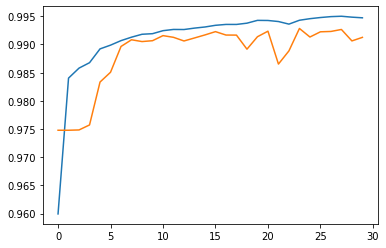

In [9]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

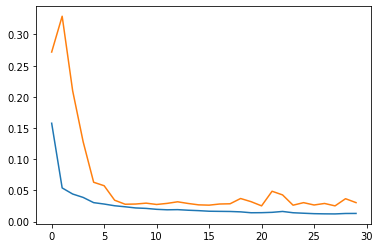

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

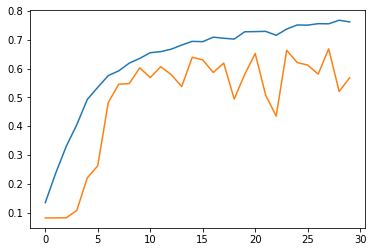

In [11]:
plt.plot(history.history['updated_mean_io_u'])
plt.plot(history.history['val_updated_mean_io_u'])

In [16]:
# get the testdata
testImgs   = getData(dataPath, testImgsFile)
testLabels = getData(dataPath, testLabelsFile)
print(testImgs.shape, testLabels.shape)

(617, 480, 480, 1) (617, 480, 480, 1)


In [22]:
trainImgs = None
trainLabels = None
valImgs = None
valLabels = None

In [19]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 11s 18ms/sample - loss: 0.0264 - accuracy: 0.9913 - updated_mean_io_u: 0.5768


[0.026397340697035605, 0.99133056, 0.576809]

In [20]:
# save the model weights
weightFileName = "PSPEfficientNetb0_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
#model.save_weights(weightPath + "/" + weightFileName)


In [12]:
model.load_weights(weightPath + "/" + weightFileName)
#model.evaluate(testImgs, testLabels)

In [21]:
modelFileName = "PSPEfficientNetb0_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET'
model.save(modelPath + "/" + modelFileName)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET/PSPEfficientNetb0_30e_16b/assets


In [23]:
# Check the GPU configuration
!nvidia-smi

Fri May 28 17:57:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |  14870MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
y_preds = tf.argmax(model.predict(testImgs), axis=-1)
#y_preds = (y_preds >= 0.5).astype(np.uint8)

In [ ]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

In [ ]:
# compute the mean per-class IOU
numClasses = 12

classIOU = []

for i in range(numClasses):
  rowSum = np.sum(values[i,:])
  colSum = np.sum(values[:,i])
  denom = rowSum + colSum - values[i,i]
  iou = values[i,i]/denom
  classIOU.append(iou)

print(classIOU)
perClassIoU = np.array(classIOU)
print(np.mean(perClassIoU))


In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(y_preds[i])
plt.show()

print(np.unique(y_preds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()